# Matched-filtering for signal extraction with PyCBC

[PyCBC](http://pycbc.org) is a python library used to study gravitational-wave data, primarily in order to find astrophysical sources due to compact binary mergers, and study their parameters.

In [3]:
import sys
!{sys.executable} -m pip install "gwpy==0.14.0" "lalsuite==6.53" "pycbc==1.13.4"

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
/Users/duncan/opt/miniconda3/envs/py27/lib/python2.7/site-packages/pip/_vendor/msgpack/fallback.py:222: PendingDeprecationWarning: encoding is deprecated, Use raw=False instead.
  PendingDeprecationWarning)
    100% |████████████████████████████████| 41.1MB 321kB/s ta 0:00:011
    100% |████████████████████████████████| 3.0MB 3.3MB/s ta 0:00:011


  Stored in directory: /Users/duncan/Library/Caches/pip/wheels/f6/47/85/1f192328f9c3156e47f7f19d34a66839c9b70407ef9e8111e2
Successfully built pycbc
pycbc 1.13.4 has requirement numpy<1.15.3,>=1.13.0, but you'll have numpy 1.15.4 which is incompatible.
  Found existing installation: lalsuite 6.52
Cannot uninstall 'lalsuite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


## Generate waveform models in PyCBC

Here we'll generate the gravitational waveform using one of the available waveform approximants. These can be generated as a time series using [`get_td_waveform`](http://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform). There are some additional examples using this interface [here](http://pycbc.org/pycbc/latest/html/waveform.html). The key parameters are the masses of the binary (given in solar masses), the time between samples (in seconds), the starting gravitational-wave frequency (Hz) and the name of the approximant we'd like to generate. A variety of approximants are available that include different physical effects. A full review of the different models is outside of the scope of this tutorial.

In this example, we've chosen to use the 'SEOBNRv4_opt' model. There are many others available as well with different methodologies and which include different physical effects. This is an implementation of the model introduced [in this paper](https://arxiv.org/pdf/1611.03703.pdf). It models the gravitational waveform of inspiralling and merging black holes, and includes the ability for each black hole to spin in the same direction as the orbit (aligned spin).


Text(0.5,0,'Time (s)')

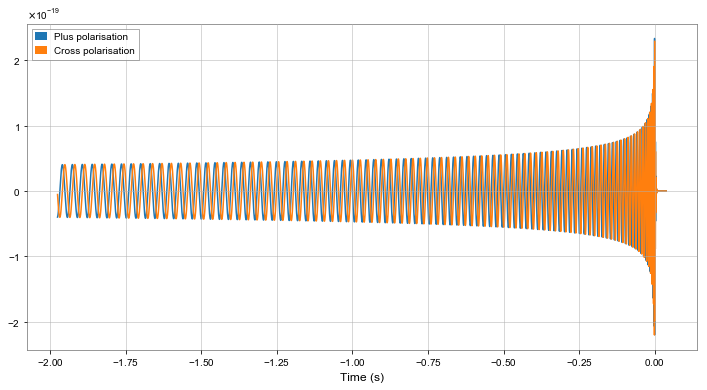

In [15]:
%matplotlib inline
from pycbc.waveform import get_td_waveform

# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(
    approximant="SEOBNRv4_opt",
    mass1=10,
    mass2=10,
    delta_t=1.0/4096,
    f_lower=30,
)

from matplotlib import pyplot
plot = pyplot.figure(figsize=(12, 6))
ax = plot.gca()
ax.plot(hp.sample_times, hp, label="Plus polarisation")
ax.plot(hc.sample_times, hc, label="Cross polarisation")
ax.legend()
ax.set_xlabel('Time (s)')

We can zoom into the merger region to get a better look:

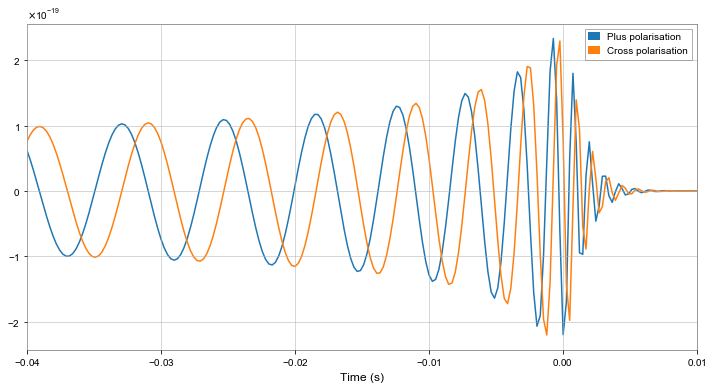

In [16]:
ax.set_xlim(-.04, .01)
plot

## How does the waveform change with the mass of the binary?

Below you can see how the length of the waveform increases for lower mass binary mergers.

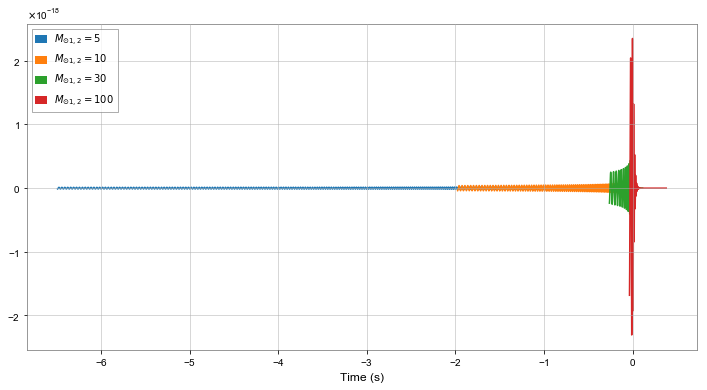

In [23]:
fig, ax = pyplot.subplots(figsize=(12, 6))

# Component mass of each binary component. We'll simplify here and assume that each 
# component of the binary has the same mass. Again, units are in solar masses.
for m in [5, 10, 30, 100]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)
    
    ax.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
ax.legend()
ax.grid(True)
ax.set_xlabel('Time (s)')
pyplot.show(fig)

## Changing the distance of the waveform

The distance of the waveform is also selectable when you generate a waveform. The units used are Megaparsecs. Keep in mind that no redshift effects are taken into account here, so there is a simple linear relationship between distance and amplitude

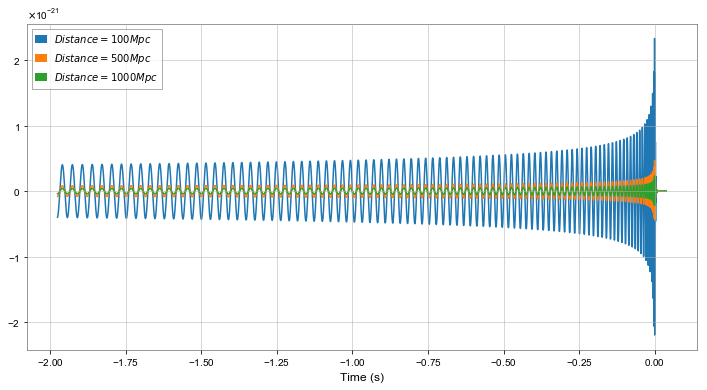

In [22]:
fig, ax = pyplot.subplots(figsize=(12, 6))

for d in [100, 500, 1000]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=d)
    
    ax.plot(hp.sample_times, hp, label='$Distance=%sMpc$' % d)
ax.legend()
ax.grid(True)
ax.set_xlabel('Time (s)')
pyplot.show(fig)

## Looking for a specific signal in the data

If you know what signal you are looking for in the data, then matched filtering is known to be the optimal method in Gaussian noise to extract the signal. Even when the parameters of the signal are unkown,  one can test for each set of parameters one is interesting in finding.

The matched filter is defined as follows:

In [29]:
%%latex
\begin{equation}
    \huge
    \left(h|s\right) = 4\operatorname{Re} %
                           \int_{0}^\infty df\,%
                               \frac{\tilde{h}^*(f)\tilde{s}(f)}{S_n(f)},
    \label{eqn:inner_product}
\end{equation}

<IPython.core.display.Latex object>

To demonstrate, we download the data associated with GW150914 for LIGO-Hanford.

In [25]:
from gwpy.timeseries import TimeSeries
data = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)

Next we need to calculate _S<sub>n</sub>(f)_, the power spectrum of the data:

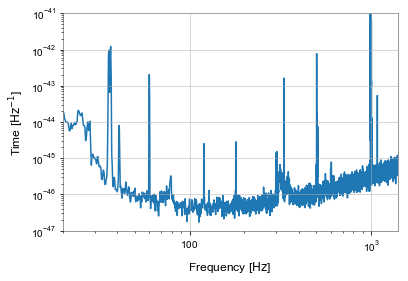

In [35]:
high = data.highpass(15)
psd = high.psd(4, 2)
plot = psd.plot(xlim=(20, 1400), ylim=(1e-47, 1e-41))

Now we can generate a waveform model against which to filter. For this we choose the waveform that matches well the GW150914 event:

In [39]:
from pycbc.waveform import get_fd_waveform
template, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32,
                        f_lower=20, f_final=2048, delta_f=psd.df.value)

And now we can calculate the SNR using the matched filter:

Text(0.5,1,'LIGO-Hanford signal-correlation for GW150914')

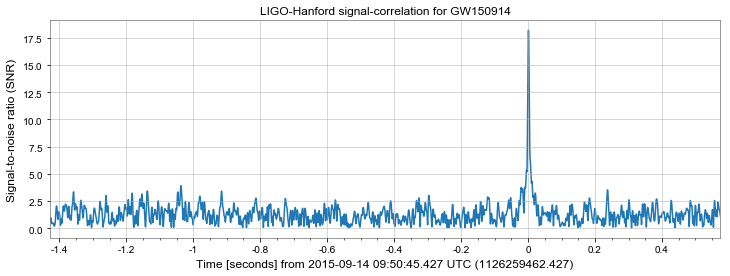

In [45]:
from pycbc.filter import matched_filter
data = high.crop(1126259460, 1126259464).to_pycbc()
snr = matched_filter(
    template,
    data,
    psd=psd.to_pycbc(),
    low_frequency_cutoff=15,
)
snrts = TimeSeries.from_pycbc(snr).abs()
plot = snrts.plot()
ax = plot.gca()
ax.set_xlim(1126259461, 1126259463)
ax.set_epoch(1126259462.427)
ax.set_ylabel('Signal-to-noise ratio (SNR)')
ax.set_title('LIGO-Hanford signal-correlation for GW150914')